# 

In [1]:
import glob
import os
import json
import pickle  
import yaml 
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import utils_farouk2 as utils
plt.rcParams.update({"font.size": 20})


In [2]:
#year = "2016"
#years = ['2016']

year = "2018"
years = ['2018']

channels = [ "ele","mu"]

#channels = [ "mu"]
#plotChannel='muon'

#channels = [ "ele"]
plotChannel='emu'


#note: for Top CR, use fake for electron channel, QCD for muon channel

samples_dir="/uscms/home/jieun201/nobackup/YOURWORKINGAREA/oct4_wjet_2018/oct3_2018_826pm_2018"

samples = [  # "WH", "ZH",
    #"VH",    
    #"ggF", "VBF", "ttH",#"HTauTau",
            "TTbar", "SingleTop",
           "WJetsLNu",
           "DYJets",      
          "WZQQ",  
          "Diboson", 
      "EWKvjets",
        "QCD",
           "Data",
    #"Fake",
          ]
samples_to_plot = samples



In [3]:
#events_dict = utils.event_skimmer(year, channels, samples_dir, samples, "all", add_qcd_score=False, add_top_score=False, add_inclusive_score=False)

In [4]:
events_dict = utils.event_skimmer_noInference(year, channels, samples_dir, samples, "all", add_qcd_score=False, add_top_score=False, add_inclusive_score=False)

luminosity 59816.23
is data
is data
is data
is data
is data
is data
is data
is data
luminosity 59781.96
is data
is data
is data
is data
is data
is data
is data
is data


In [5]:
color_by_sample = {
    "ggF": "lightsteelblue",
    "VBF": "peru",
    "VH": "red", 
    "ttH": "tab:olive",
    # background
    "QCD": "tab:orange",
    "Fake": "tab:orange",
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "Diboson": "orchid",
    "SingleTop": "tab:cyan",
    "EWKvjets": "tab:grey",
    "DYJets": "tab:purple",
    "WZQQ": "khaki",
   
}
plot_labels = {    "ggF": "ggF",
   # "WH": "WH",
   # "ZH": "ZH",
    "VH": "VH",
    # "VH": "VH(WW)",
    # "VBF": r"VBFH(WW) $(qq\ell\nu)$",
    "VBF": r"VBF",
    # "ttH": "ttH(WW)",
    "ttH": r"$t\bar{t}$H",
    "QCD": "Multijet",
    "Fake": "Fake",
    "Diboson": "VV",
    "WJetsLNu": r"W$(\ell\nu)$+jets",
    "TTbar": r"$t\bar{t}$+jets",
    "SingleTop": r"Single Top",
    "EWKvjets": "EWK VJets",
    "DYJets": r"Z$(\ell\ell)$+jets",
    "WZQQ": r"V$(qq)$",
                    }
#label_by_ch = { "lep": "Lepton",}
label_by_ch = {
    "mu": "Muon",
    "ele": "Electron"
}


In [6]:
def plot_hists(
    years, channels, hists, vars_to_plot, add_data, logy, add_soverb, only_sig, mult, text_="", blind_region=None
):
    # luminosity
    luminosity = 0
    for year in years:
        lum = 0
        for ch in channels:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        luminosity += lum / len(channels)

    for var in vars_to_plot:
        if var not in hists.keys():
            print(f"{var} not stored in hists")
            continue

      #  print(f"Will plot {var} histogram")

        # get histograms
        h = hists[var]

        if h.shape[0] == 0:  # skip empty histograms (such as lepton_pt for hadronic channel)
            print("Empty histogram ", var)
            continue

        # get samples existing in histogram
        samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
        signal_labels = [label for label in samples if label in utils.signals]
        bkg_labels = [label for label in samples if (label and label not in signal_labels and (label not in ["Data"]))]

        # get total yield of backgrounds per label
        # (sort by yield in fixed fj_pt histogram after pre-sel)
        order_dic = {}
        for bkg_label in bkg_labels:
         #   print('hist.keys', hists.keys())
            if "fj_pt" in hists.keys():
                #order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
                order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum().value                #March 21 )changed this to sum().value
            else:
                #order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()
                order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum().value                    #March 21 )changed this to sum().value
        
        # data
        if add_data:
            data = h[{"samples": "Data"}]

        # signal
        signal = [h[{"samples": label}] for label in signal_labels]
        
        # scale signal for non-log plots
        if logy:
            mult_factor = 1
        else:
            mult_factor = mult
        signal_mult = [s * mult_factor for s in signal]

        #********************************************************************************************************
        # background
        bkg = [h[{"samples": label}] for label in bkg_labels]

        #np.asarray(bkg[0].values())[bkg[0].values() < 0] = 0.001
        
#********************************************************************************************************
        
        if add_data and data and len(bkg) > 0:
            if add_soverb and len(signal) > 0:
                fig, (ax, rax, sax) = plt.subplots(
                    nrows=3,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                    sharex=True,
                )
            else:
                fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                sax = None
        else:
            if add_soverb and len(signal) > 0:
                fig, (ax, sax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                rax = None
            else:
                fig, ax = plt.subplots(figsize=(8, 8))
                rax = None
                sax = None

        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
        }

        # sum all of the background
        if len(bkg) > 0:
            tot = bkg[0].copy()

            np.asarray(tot.values())[tot.values() < 0] = 0.001

            
            for i, b in enumerate(bkg):
               # print('i,b', i,b)
                np.asarray(b.values())[b.values() < 0] = 0.001
                if i > 0:
                    tot = tot + b     

            tot_val = tot.values()
            tot_val_zero_mask = tot_val == 0   #check if this is for the ratio or not, 
            tot_val[tot_val_zero_mask] = 1 

            tot_err = np.sqrt(tot.variances())   #March 21, changed this
            #print('tot_err', tot_err)
            
        if add_data and data:
            data_err_opts = {
                "linestyle": "none",
                "marker": ".",
                "markersize": 10.0,
                "elinewidth": 1,
            }
#*************BLIND REGION**********************************************************************************************
            if blind_region:
                print('blind_region', blind_region)
                print('blind[0]', blind_region[0])
                massbins = data.axes[-1].edges
                print('massbins', massbins)
                lv = int(np.searchsorted(massbins, blind_region[0], "right"))  #get the third mass bin it seems
                rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)
                print('lv', lv)
                print('rv', rv)
                data.view(flow=True)[lv:rv].value = 0
                data.view(flow=True)[lv:rv].variance = 0
                #data.view(flow=True)[lv:rv] = 0
                #data.view(flow=True)[lv:rv].variance = 0

            hep.histplot(
                data,
                ax=ax,
                histtype="errorbar",
                color="k",
                capsize=4,
                yerr=True,
                label="Data",
                **data_err_opts,
            )

            if len(bkg) > 0:
                from hist.intervals import ratio_uncertainty

                data_val = data.values()
                data_val[tot_val_zero_mask] = 1

                yerr = ratio_uncertainty(data_val, tot_val, "poisson")

                hep.histplot(
                    data_val / tot_val,
                    tot.axes[0].edges,
                    yerr=yerr,
                    ax=rax,
                    histtype="errorbar",
                    color="k",
                    capsize=4,
                )

                rax.axhline(1, ls="--", color="k")
                rax.set_ylim(0.2, 1.8)

        # plot the background
        if len(bkg) > 0 and not only_sig:
            hep.histplot(
                bkg,
                ax=ax,
                stack=True,
                sort="yield",
                edgecolor="black",
                linewidth=1,
                histtype="fill",
                label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
                color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
            )
            ax.stairs(
                values=tot.values() + tot_err,
                baseline=tot.values() - tot_err,
                edges=tot.axes[0].edges,
                **errps,
                label="Stat. unc.",
            )

        ax.text(0.5, 0.9, text_, fontsize=14, transform=ax.transAxes, weight="bold")

        # plot the signal (times 10)
        if len(signal) > 0:
            tot_signal = None
            for i, sig in enumerate(signal_mult):
                lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
                if mult_factor == 1:
                    lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
                hep.histplot(
                    sig,
                    ax=ax,
                    label=lab_sig_mult,
                    linewidth=3,
                    color=color_by_sample[signal_labels[i]],
                )

                if tot_signal == None:
                    tot_signal = signal[i].copy()
                else:
                    tot_signal = tot_signal + signal[i]

            # plot the total signal (w/o scaling)
          #  hep.histplot(
           #     tot_signal, ax=ax, label=f"VH", linewidth=3, color="tab:red"
           # )
            # add MC stat errors
            ax.stairs(
                values=tot_signal.values() + np.sqrt(tot_signal.values()),
                baseline=tot_signal.values() - np.sqrt(tot_signal.values()),
                edges=sig.axes[0].edges,
                **errps,
            )

            if sax is not None:
                totsignal_val = tot_signal.values()
              #  print('totsignal_val', totsignal_val)
                # replace values where bkg is 0
                totsignal_val[tot_val == 0] = 0
                soverb_val = totsignal_val / np.sqrt(tot_val)
                hep.histplot(
                    soverb_val,
                    tot_signal.axes[0].edges,
                    label="Total Signal",
                    ax=sax,
                    linewidth=3,
                    color="tab:red",
                )

 
        ax.set_ylabel("Events")
        if sax is not None:
            ax.set_xlabel("")
            if rax is not None:
                rax.set_xlabel("")
                rax.set_ylabel("Data/MC", fontsize=20)
            sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
            sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis
            
        elif rax is not None:
            ax.set_xlabel("")
            rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis
            
            rax.set_ylabel("Data/MC", fontsize=20)

        # get handles and labels of legend
        handles, labels = ax.get_legend_handles_labels()

        # append legend labels in order to a list
        summ = []
        for label in labels[: len(bkg_labels)]:
            summ.append(order_dic[label])
            #print('order_dic[label])', label, order_dic[label])  #here Fake is fine
            
        # get indices of labels arranged by yield
        order = []
        for i in range(len(summ)):
            order.append(np.argmax(np.array(summ)))
            summ[np.argmax(np.array(summ))] = -1000 #changed this to -1000 since Fakes gave something greater than -100

        # plot data first, then bkg, then signal
        hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
        lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

        print('lab', lab)
            

        if len(channels) == 2:
            ax.legend(
                [hand[idx] for idx in range(len(hand))],   [lab[idx] for idx in range(len(lab))],   bbox_to_anchor=(1.05, 1),  loc="upper left",  title=f"Semi-Leptonic Channel",
            )        
        else:
            ax.legend(
                [hand[idx] for idx in range(len(hand))],  [lab[idx] for idx in range(len(lab))],  bbox_to_anchor=(1.05, 1),   loc="upper left",   title=f"{label_by_ch[ch]} Channel",
            )
        
        if logy:
            ax.set_yscale("log")
            ax.set_ylim(1e-1)
        hep.cms.lumitext(  "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20 )
       # hep.cms.text("Work in Progress", ax=ax, fontsize=15)     

In [7]:
#events_dict['ele']['TTbar']['weight_btag'].hist()


In [8]:
#my_list = list(events_dict['ele']['VH'])


lab ['Data', '$t\\bar{t}$+jets', 'Single Top', 'W$(\\ell\\nu)$+jets', 'Multijet', 'Z$(\\ell\\ell)$+jets', 'VV', 'V$(qq)$', 'EWK VJets', 'Stat. unc.']


<Figure size 400x400 with 0 Axes>

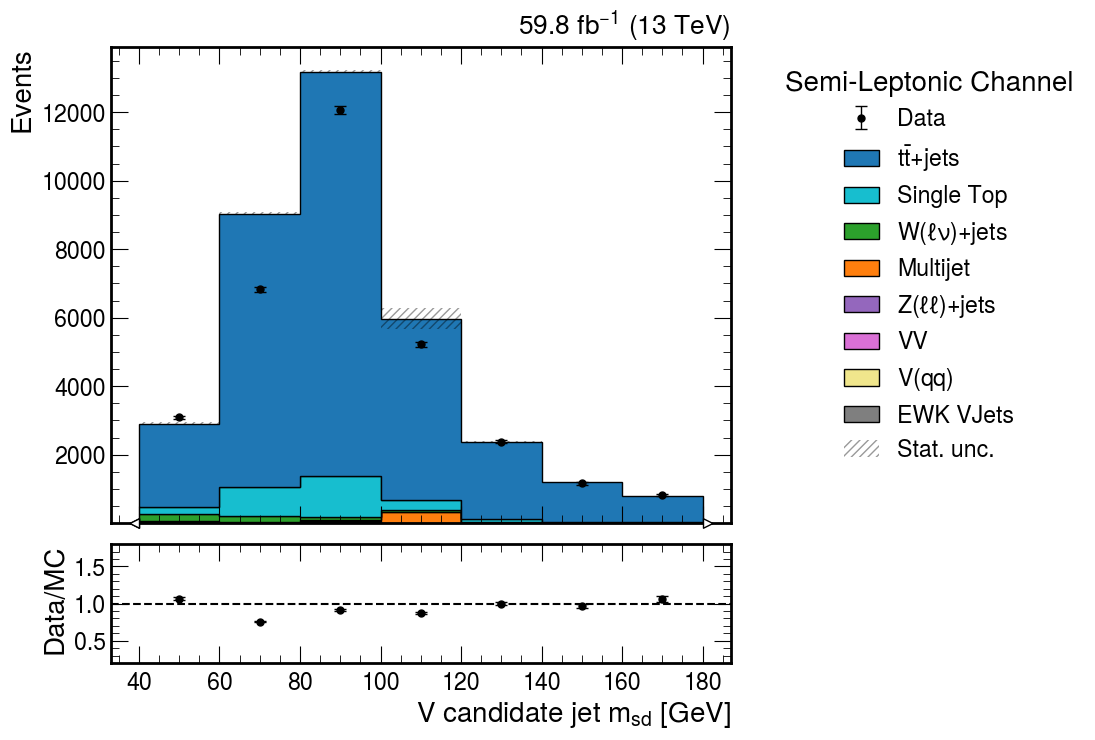

In [9]:
vars_to_plot = ["fj_mass"]
hists = {}
for var in vars_to_plot:            
    hists[var] = hist2.Hist( hist2.axis.StrCategory([], name="samples", growth=True),   utils.axis_dict[var], storage=hist2.storage.Weight(),)      
    for sample in samples_to_plot:
        for ch in channels:
            df = events_dict[ch][sample]
            df = df[       (df["lep_fj_dr"] > 1.0 )   & (df["numberBJets_Medium_OutsideWFatJet"] > 0) 
        & (df['met_pt']> 30) 
        &   (df["numberLeptons"] == 1) 
        & (df["fj_pt"] > 250) & (df["fj_pt"] < 2000) 
     #   & (df["WJet_deltaR_W"] < 0.8) 
            & (df["VScore_WJet"] > 0.9)  


]  
            if var == "fj_mass":
                hists[var].fill( samples=sample,var=df["fj_mass"],
                    weight=df["event_weight"] )
plt.figure(figsize=(4,4))
plot_hists(  years, channels, hists, vars_to_plot, True, False,True,False, 1, text_="", )  
plt.savefig(f"/home/jieun201/may18/boostedhiggs/python/wJetPlots_Prefit/{plotChannel}_{year}_pass.png", bbox_inches='tight')

lab ['Data', '$t\\bar{t}$+jets', 'Multijet', 'W$(\\ell\\nu)$+jets', 'Single Top', 'Z$(\\ell\\ell)$+jets', 'VV', 'V$(qq)$', 'EWK VJets', 'Stat. unc.']


<Figure size 400x400 with 0 Axes>

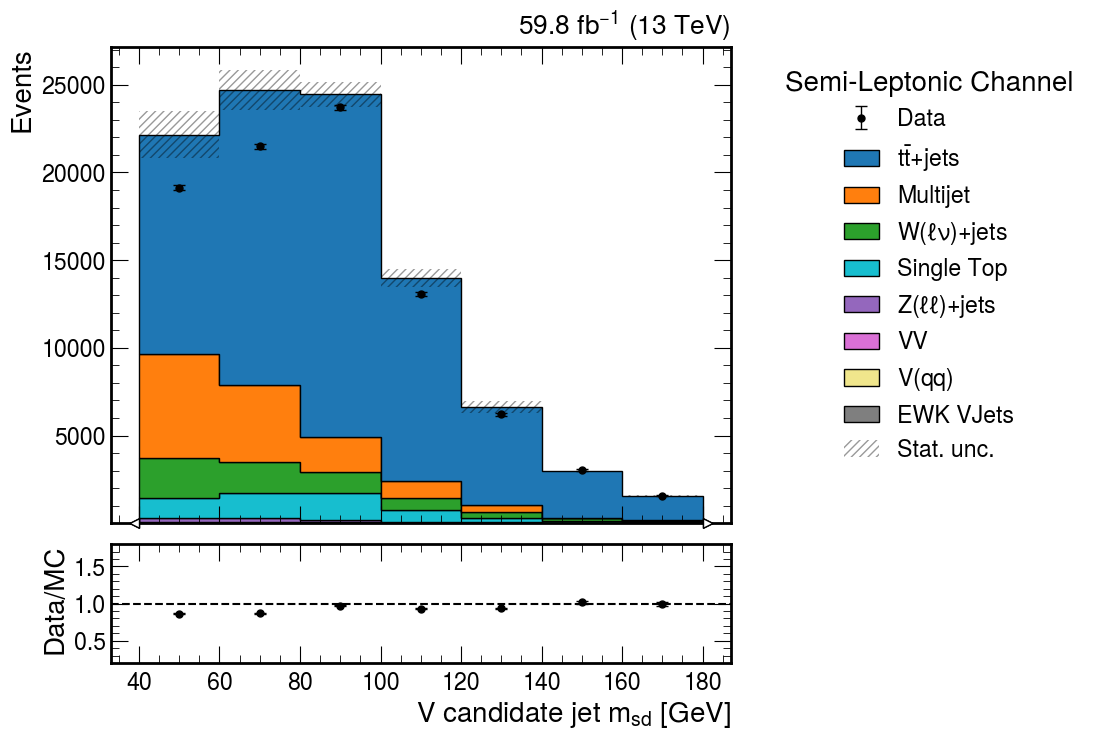

In [10]:
vars_to_plot = ["fj_mass"]
hists = {}
for var in vars_to_plot:            
    hists[var] = hist2.Hist( hist2.axis.StrCategory([], name="samples", growth=True),   utils.axis_dict[var], storage=hist2.storage.Weight(),)      
    for sample in samples_to_plot:
        for ch in channels:
            df = events_dict[ch][sample]
            df = df[       (df["lep_fj_dr"] > 1.0 )   & (df["numberBJets_Medium_OutsideWFatJet"] > 0) 
        & (df['met_pt']> 30) 
        #& (df["fj_msoftdrop"] > 60) & (df["fj_msoftdrop"] < 120)
        &   (df["numberLeptons"] == 1) 
        & (df["fj_pt"] > 250) & (df["fj_pt"] < 2000) 
     #   & (df["WJet_deltaR_W"] < 0.8) 
            & (df["VScore_WJet"] < 0.9)  


]  
            if var == "fj_mass":
                hists[var].fill( samples=sample,var=df["fj_mass"],
                    weight=df["event_weight"] )
plt.figure(figsize=(4,4))
plot_hists(  years, channels, hists, vars_to_plot, True, False,True,False, 1, text_="", )  
plt.savefig(f"/home/jieun201/may18/boostedhiggs/python/wJetPlots_Prefit/{plotChannel}_{year}_fail.png", bbox_inches='tight')